In [52]:
import pandas as pd

In [54]:
df_raw = pd.read_csv('../data/raw/ATM cash balance.csv')
df_raw['柜员号'] = df_raw['柜员号'].apply(lambda counter_str: counter_str.rstrip().rstrip('现金尾箱'))
df_raw['柜员号'] = df_raw['柜员号'].astype(int)
df_raw['日期'] = pd.to_datetime(df_raw['日期'], format='%Y%m%d')

df_raw.columns = ['date', 'atm', 'balance']
print(df_raw.info())
df_raw

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169731 entries, 0 to 169730
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     169731 non-null  datetime64[ns]
 1   atm      169731 non-null  int32         
 2   balance  169731 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 3.2 MB
None


,date,atm,balance
0,2016-02-01,9012,600
1,2016-02-01,9173,406400
2,2016-02-01,9095,2100
3,2016-02-01,9008,173300
4,2016-02-01,9022,179900
...,...,...,...
169726,2017-12-31,9260,0
169727,2017-12-31,9148,0
169728,2017-12-31,9057,0
169729,2017-12-31,9687,0


In [60]:
df_raw['atm'].value_counts()

atm
9338    1462
9176    1462
9175    1462
9339    1462
9152    1462
        ... 
9877      42
9875      28
9873      28
9874      23
9876      23
Name: count, Length: 240, dtype: int64

# Check Duplicate Date and Drop

In [203]:
# check duplicate date
def check_duplicate_date(df):
    duplicate_date_series = []
    for g, g_df in df.groupby('atm'):
        _ = g_df['date'].value_counts(ascending=False)
        if _.sum() != _.shape[0]:
            print(g)
            duplicate_date_series.append(g)
    return duplicate_date_series
    
duplicate_date_series = check_duplicate_date(df_raw)
duplicate_date_series

9152
9175
9176
9338
9339


[9152, 9175, 9176, 9338, 9339]

In [194]:
to_be_dropped_index = []
for duplicate_date_s in duplicate_date_series:
    _df = df_raw[df_raw['atm'] == duplicate_date_s]
    for g, g_df in _df.groupby('date'):
        g_df_new = g_df.reset_index(inplace=False)
        print(g_df)
        # assert g_df_new.loc[0, 'balance'] == g_df_new['balance'].sum(), (duplicate_date_s, g, g_df_new.loc[0, 'atm'], g_df_new['atm'].sum())
        if g_df['balance'].sum() == 0:
            to_be_dropped_index += list(g_df.index[1:])
        elif g_df['balance'].sum() > 0:
            id = g_df_new[g_df_new['balance'] == 0]['index'].item()
            assert type(id) is int
            to_be_dropped_index.append(id)
        else:
            assert False

          date   atm  balance
177 2016-02-01  9152        0
188 2016-02-01  9152        0
          date   atm  balance
364 2016-02-02  9152   191300
371 2016-02-02  9152        0
          date   atm  balance
556 2016-02-03  9152   193700
563 2016-02-03  9152        0
          date   atm  balance
747 2016-02-04  9152   259400
754 2016-02-04  9152        0
          date   atm  balance
938 2016-02-05  9152   223600
945 2016-02-05  9152        0
           date   atm  balance
1129 2016-02-06  9152   211100
1136 2016-02-06  9152        0
           date   atm  balance
1320 2016-02-07  9152   208500
1327 2016-02-07  9152        0
           date   atm  balance
1511 2016-02-08  9152   204000
1518 2016-02-08  9152        0
           date   atm  balance
1702 2016-02-09  9152   217600
1709 2016-02-09  9152        0
           date   atm  balance
1893 2016-02-10  9152   215600
1900 2016-02-10  9152        0
           date   atm  balance
1926 2016-02-11  9152   215600
2091 2016-02-11  9152  

In [205]:
df_pro1 = df_raw.drop(to_be_dropped_index)
check_duplicate_date(df_pro1)

[]

# Select ATMs

In [209]:
_ = df_pro1['atm'].value_counts()
use_col = _[_ == 731].index
use_col

Index([9012, 9384, 9336, 9173, 9391, 9392, 9373, 9374, 9379, 9380,
       ...
       9194, 9195, 9214, 9191, 9192, 9193, 9213, 9211, 9212, 9198],
      dtype='int32', name='atm', length=186)

# Check date alignment

In [220]:
df_use = df_pro1[df_pro1['atm'].isin(use_col)]

# check whether the date is aligned among all ATMs
use_col = list(use_col)
for g, g_df in df_use.groupby('date'):
    _ = g_df['atm'].tolist()
    assert len(_) == len(use_col), _
    assert set(_) == set(use_col), _

# Check date continuity

In [228]:
# check whether the date is continuous
prior = 'init'
for g, g_df in df_use.groupby('date'):
    if prior == 'init':
        prior = g
    else:
        assert prior + pd.DateOffset(days=1) == g, (prior, g)
        prior = g

# Expand along ATMs in each day

In [273]:
s_list = []
for g, g_df in df_use.groupby('date'):
    s_list.append(g_df.set_index('atm').loc[use_col, 'balance'].rename(g))

df_final = pd.DataFrame(s_list)
df_final

atm,9012,9384,9336,9173,9391,9392,9373,9374,9379,9380,...,9194,9195,9214,9191,9192,9193,9213,9211,9212,9198
2016-02-01,600,112800,52800,406400,764700,472200,72300,89900,51400,54200,...,56600,89100,162900,265700,334700,19800,59100,187100,214500,89200
2016-02-02,504000,84700,29800,172100,670600,518200,37200,88100,58400,64400,...,23600,46600,230500,199200,298000,52800,204800,156800,218600,42500
2016-02-03,467300,47500,10300,526800,60500,17200,269700,260700,167500,288600,...,74700,95900,233700,281600,215900,61500,264500,244400,244000,212300
2016-02-04,382200,11300,55400,532100,77900,61700,258300,227000,146200,196300,...,119100,147000,216100,282900,257000,152900,254200,231300,225000,158900
2016-02-05,298700,268600,99300,522600,282600,205800,284900,209400,206400,151600,...,137600,168900,204400,332400,254100,251000,275600,215800,221900,198500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-27,215100,40200,301000,40600,13300,58500,319200,203700,140500,133300,...,219500,103600,214800,149300,28500,245900,188400,175100,222400,103620
2018-01-28,187800,10200,290200,34900,30800,44500,306200,216600,139600,228500,...,234900,123000,235800,334400,2500,221200,214300,221900,188500,129090
2018-01-29,163500,13000,62600,74700,19800,99000,297100,211600,125600,144000,...,234900,120100,264900,386400,7600,177900,313500,256500,180300,172510
2018-01-30,139000,8300,84000,77200,60400,57300,70000,83700,211400,201400,...,209900,117900,41200,354800,32200,117200,120500,267400,229400,157410


# Check NaN

In [282]:
pd.isna(df_final).sum().sum()

0

<Axes: >

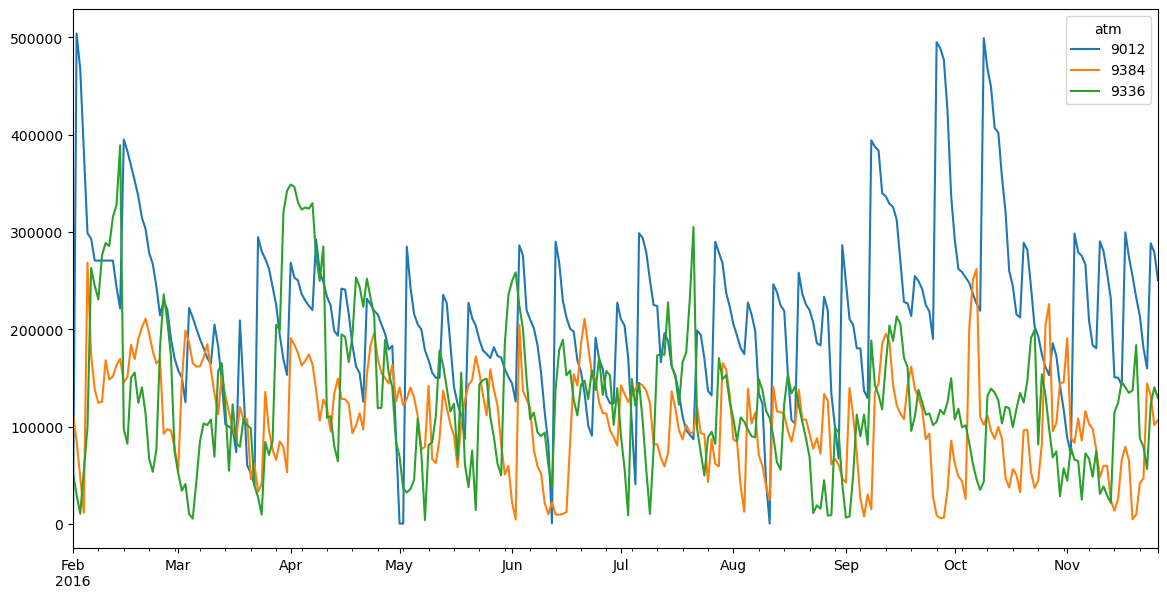

In [286]:
df_final.iloc[:300, :3].plot(figsize=(14, 7))

# Save

In [288]:
df_final.to_csv('../data/processed/data.csv')

In [289]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-02-01 to 2018-01-31
Columns: 186 entries, 9012 to 9198
dtypes: int64(186)
memory usage: 1.0 MB


<Axes: xlabel='date'>

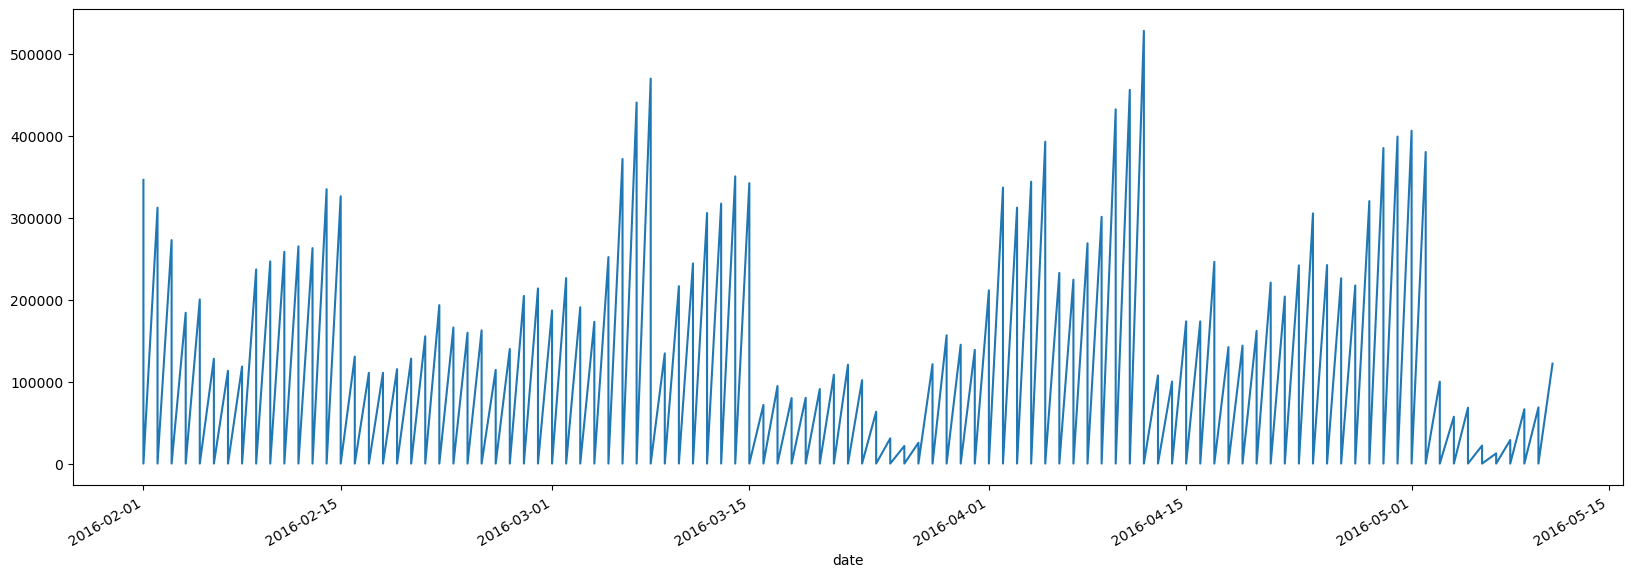

In [92]:
df_raw[df_raw['atm'] == 9339].reset_index().loc[:200].set_index('date')['balance'].plot(figsize=(20, 7))